# **SYNAPSE 2023-24 Co-Committee ML Interview Task 4**

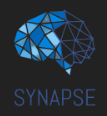

---
> This is a Bonus Hard Tier Task. It is not mandatory to complete the task, but doing
this task will give you an edge over others in the selection process and learn more into the ever-growing field of ML.





**Instructions**



> In task 4, we expect you to train a Machine Learning Model that can efficiently predict the type of Nature scene from their corresponding images.

> It is a Deep Learning Multi Label Classification problem where we are going to build a Convolutional Neural Network.

> Resources for creating the model are provided just above each cell. Do go through the material, learn the concepts and then start applying.

> Relevant code snippets are provided to simplify the process. So have fun completing this Task!!! :D

**The Task**

> Below is the diagram of a sample architecture that you're expected to build. After building the model, you have to write the loss function and Pipeline for the model and run it on the MIML Nature Scene dataset.

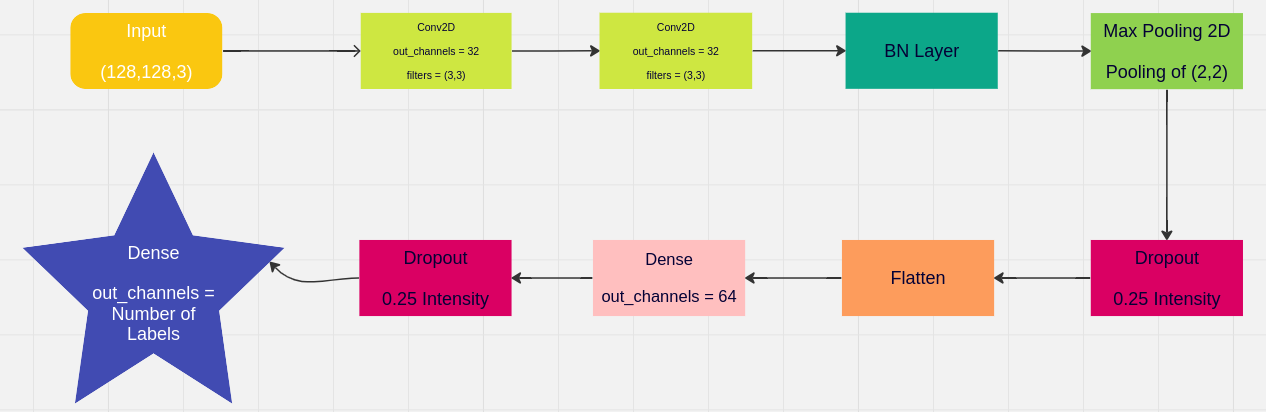

**Dataset Description**


> ***Context***

The complete description of dataset is given on http://lamda.nju.edu.cn/data_MIMLimage.ashx. The dataset contains 2000 natural scenes images.


> ***Content***

- Dataset contains 2,000 natural scene images.
- Each image is assigned a set of labels artificially.
- Labels include: desert, mountains, sea, sunset, and trees.
- Multiple labels (e.g. sea+sunset) make up >22% of dataset.
- Combined classes (e.g. mountains+sunset+trees) are very rare.
- Average of 1.24 class labels per image.


> ***Acknowledgements***

We wouldn't be here without the help of others. Credits for this dataset go to Z.-H. Zhou from NJU LAMDA. Thank you so much!

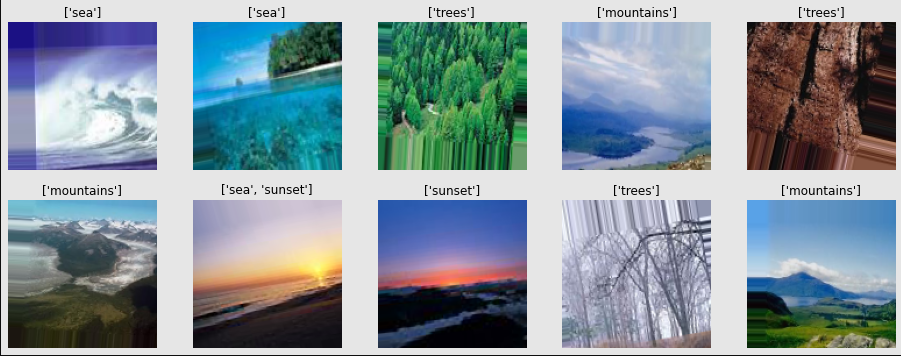

# Start Coding

### Importing all the necessary libraries

In [2]:
!pip install ydata-profiling -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling as pp
import numpy as np
from sklearn.metrics import accuracy_score,classification_report,f1_score, precision_recall_curve

import tensorflow as tf
from keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings('ignore')

params = {'figure.figsize' : (16, 8),
          'legend.fontsize': 16,
          'legend.handlelength': 2,
          'axes.titlesize' : 'large'}
sns.set(style="white")
plt.rcParams.update(params)
%matplotlib inline
%load_ext tensorboard
%reload_ext tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 27.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Global Variables

In [4]:
epochs = 40
la1=pd.read_csv("/content/gdrive/MyDrive/Synapse/miml_dataset/miml_labels_1.csv")
image_directory = "/content/gdrive/MyDrive/Synapse/miml_dataset/images"
class_list = list(la1.columns[1:])

### Data Preprocessing

In [5]:
pp.ProfileReport(la1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Go through this article about the need of a ImageDataGenerator https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

In [6]:
## Fill this according to what you understood from ImageDataGenerator

train_datagen=ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode="nearest",
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=la1[:1800],
directory=image_directory,
x_col="Filenames",
y_col=class_list,
batch_size=32,#kyu hai yeh
shuffle=True,
class_mode="raw",
target_size=(128,128),
classes=class_list)


## Fill this according to what you understood from ImageDataGenerator as well as the above example of the Train Data Generator
valid_generator=test_datagen.flow_from_dataframe(
dataframe=la1[1800:],
directory=image_directory,
x_col="Filenames",
y_col=class_list,
batch_size=32,
shuffle=True,
class_mode="raw",
target_size=(128,128),
classes=class_list)

Found 1800 validated image filenames.
Found 200 validated image filenames.


This is the Expected Output

> Found 1800 validated image filenames.

> Found 200 validated image filenames.






### Loss function

To understand more about binary cross entropy go through this article about the visual analysis about binary cross entropy https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [8]:
@tf.__internal__.dispatch.add_dispatch_support
def binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1):

    y_pred = tf.convert_to_tensor(y_pred)# convert numpy array to tensor
    y_true = tf.convert_to_tensor(y_true)# cast numpy array to the type of y_pred
    label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)
    y_true = tf.__internal__.smart_cond.smart_cond(label_smoothing, lambda: y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing, lambda: y_true)
    return backend.mean(backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),axis=axis)

### Build the CNN Architecture.


> The major task is in the next cell. Here you have to use the tensorflow Model function and its attributes in order to add layers as stated in the diagram. Only use the sample architecture as given. Choose your Activation function in between the layers on your own.

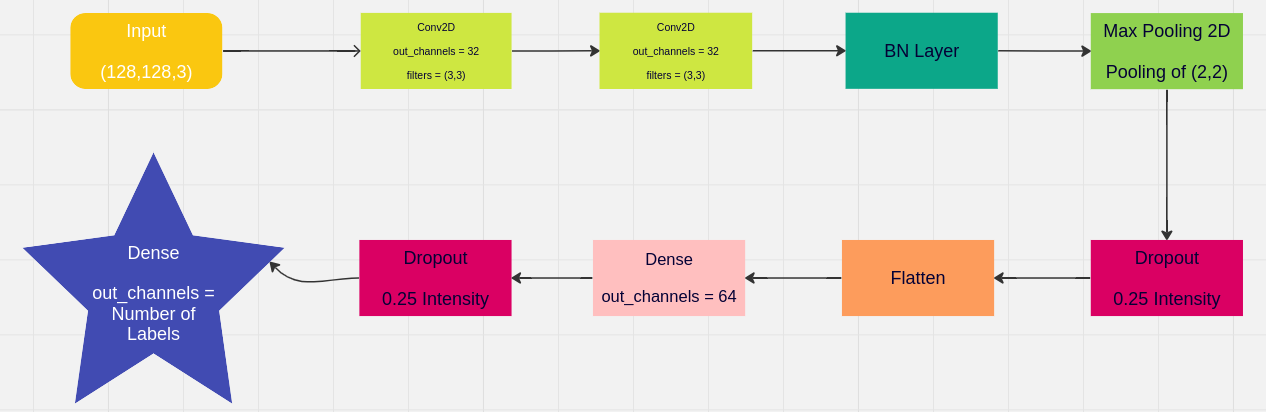

Hints:

1. Neural networks: https://www.youtube.com/watch?v=aircAruvnKk
2. CNN basics: https://www.youtube.com/watch?v=zfiSAzpy9NM
3. CNN maths and terms: https://www.youtube.com/watch?v=m8pOnJxOcqY
4. Feature learning mathematics: https://www.youtube.com/watch?v=Y1qxI-Df4Lk
5. Tensorboard: https://medium.com/neuronio/using-tensorboard-e3906a5798e6

In [50]:
inputs = Input(shape=(128,128,3))

## Make Model architecture named 'model' as given in the diagram
model = tf.keras.Sequential()
model.add(inputs)
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(len(class_list)))

model.compile(optimizer=Adamax(), loss=binary_crossentropy, metrics=['accuracy', 'binary_accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_37 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_11 (Bat  (None, 124, 124, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 62, 62, 32)        0         
                                                                 
 flatten_8 (Flatten)         (None, 123008)          

In [49]:
## Run the cell after going through the aboive resources with a good understanding of the fit and fit_generator function
tensorboard_callback = TensorBoard(log_dir='/content/gdrive/MyDrive/Synapse_logs', histogram_freq=1)
model.fit_generator(train_generator,validation_data=valid_generator,epochs=epochs,callbacks=[tensorboard_callback])

Epoch 1/40


TypeError: ignored

In [ ]:
%tensorboard --logdir '/content/gdrive/MyDrive/Synapse_logs'

### Pipeline

Go through this article to understand the formulations of different metrics https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd

7/7 [==============================] - 0s 52ms/step
Optimal threshold: 0.29821917
F1 score: 0.24754376058723887
True labels: ['trees']
Predicted labels: ['trees']


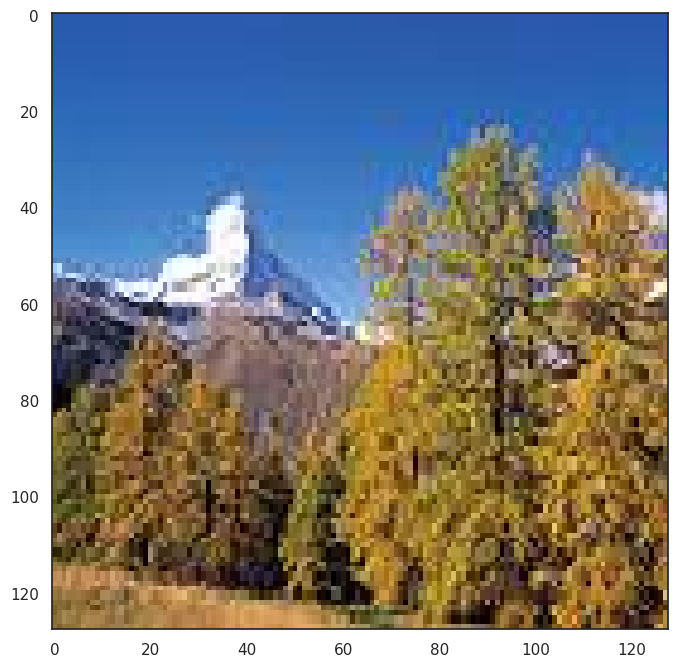

In [ ]:
def evaluate_model(model, generator):

    true_labels = generator.labels # true labels
    y_pred_proba = model.predict(generator)  # predicted probabilities
    precision, recall, thresholds = precision_recall_curve(true_labels.ravel(), y_pred_proba.ravel()) # Optimal threshold found

    # Write formula of F1 Score
    f1_scores =  2 * precision * recall / (precision + recall)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal threshold:', optimal_threshold)
    y_pred = (y_pred_proba > 0.5).astype(int)
    f1 = f1_score(true_labels, y_pred, average='macro')
    print('F1 score:', f1)
    y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
    return y_pred_optimal

def show_image_prediction(generator, model, class_list):

    y_pred_optimal = evaluate_model(model, generator)
    x, y_true = generator[0]
    img = (x * 255).astype('uint8')  # scale back the image
    true_labels = y_true[0]
    true_labels_str = [class_list[i] for i in range(len(true_labels)) if true_labels[i] == 1] # decode to string labels
    pred_labels = y_pred_optimal[0]

    # Complete the snippet
    pred_labels_str = [class_list[i] for i in range(len(pred_labels)) if pred_labels[i] == 1]

    plt.imshow(img[0])
    print('True labels:', true_labels_str)
    print('Predicted labels:', pred_labels_str)

show_image_prediction(valid_generator, model, class_list)

End of task 4
--